# Imports and MRI Data Loading

In [ ]:
!pip install nilearn
!pip install -q kaggle

#Imports for preprocessing, scikitlearn model imports still needed
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
import random
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import zipfile
from google.colab import files


In [ ]:
from google.colab import files

import os, zipfile

# 1) Upload kaggle.json
print("Upload your kaggle.json file")
uploaded = files.upload()

# 2) Find the uploaded filename dynamically
kaggle_filename = list(uploaded.keys())[0]
print("Using uploaded file:", kaggle_filename)

# 3) Put it where Kaggle CLI expects it
kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

with open(os.path.join(kaggle_dir, "kaggle.json"), "wb") as f:
    f.write(uploaded[kaggle_filename])

# 4) Fix permissions
!chmod 600 ~/.kaggle/kaggle.json

DATA_DIR = "/content/brats2020"
os.makedirs(DATA_DIR, exist_ok=True)

zip_path = os.path.join(DATA_DIR, "brats20-dataset-training-validation.zip")
extracted_dir = os.path.join(DATA_DIR, "BraTS2020_TrainingData")

# Download only if zip is missing
if not os.path.exists(zip_path):
    print("Downloading dataset from Kaggle...")
    !kaggle datasets download -d awsaf49/brats20-dataset-training-validation -p $DATA_DIR
else:
    print("Zip already exists, skipping download.")

!ls -lh $DATA_DIR

# Only unzip if we don't see the extracted folder yet
if not os.path.isdir(extracted_dir):
    print("Extracting zip... this can take a few minutes.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print("Extraction complete.")
    # Optional: delete zip to save space
    os.remove(zip_path)
    print("Removed zip file.")
else:
    print("Found extracted directory, skipping unzip.")


Upload your kaggle.json file


Saving kaggle.json to kaggle (6).json
Using uploaded file: kaggle (6).json
Zip already exists, skipping download.
total 4.2G
drwxr-xr-x 3 root root 4.0K Nov 30 20:39 BraTS2020_TrainingData
-rw-r--r-- 1 root root 4.2G Jul  2  2020 brats20-dataset-training-validation.zip
Found extracted directory, skipping unzip.


In [ ]:
!pip install nilearn
!pip install -q numpy pandas matplotlib nibabel nilearn scikit-learn scikit-fuzzy scipy
!pip install -q seaborn tqdm

In [ ]:
TEST_MODE = False  # Set to False for full dataset
MAX_TEST_PATIENTS = 3

if TEST_MODE:
    print(f"TEST MODE: Will process only {MAX_TEST_PATIENTS} patients")
else:
    print("FULL MODE: Processing all patients")


TEST MODE: Will process only 3 patients


In [ ]:
# Imports for preprocessing, scikitlearn model imports still needed
import os, random, warnings, zipfile
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

import seaborn as sns
from tqdm import tqdm
from nilearn.masking import apply_mask
from IPython.display import display

In [ ]:
# Load and Organize files
DATA_ROOT = "/content/brats2020"

TRAIN_DIR = os.path.join(
    DATA_ROOT, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData"
)

print("Train dir:", TRAIN_DIR)

def load_patient(patient_dir):
    """Load all modalities for a single BraTS patient."""
    pid = os.path.basename(patient_dir)

    def load_mod(mod):
        # Kaggle BraTS files are .nii, not .nii.gz
        f = os.path.join(patient_dir, f"{pid}_{mod}.nii")
        return nib.load(f).get_fdata().astype(np.float32)

    flair = load_mod("flair")
    t1    = load_mod("t1")
    t1ce  = load_mod("t1ce")
    t2    = load_mod("t2")
    seg   = load_mod("seg")

    return {
        "PID": pid,
        "FLAIR": flair,
        "T1": t1,
        "T1CE": t1ce,
        "T2": t2,
        "SEG": seg,
    }

patients = {}
masked_patients = {}

patient_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])

if TEST_MODE:
    patient_list = patient_list[:MAX_TEST_PATIENTS]
    print(f"TEST MODE: Processing only first {MAX_TEST_PATIENTS} patients\n")

for patient_id in patient_list:
    patient_path = os.path.join(TRAIN_DIR, patient_id)

    try:
        patient_data = load_patient(patient_path)
        patients[patient_id] = {
            "T1": patient_data["T1"],
            "T1CE": patient_data["T1CE"],
            "T2": patient_data["T2"],
            "FLAIR": patient_data["FLAIR"],
            "SEG": patient_data["SEG"]
        }
        print(f"Loaded {patient_id} → {list(patients[patient_id].keys())}")
    except Exception as e:
        print(f"Skipped {patient_id} (error: {e})")

print(f"\n Total patients loaded: {len(patients)}")
if len(patients) == 0:
    print(f"WARNING: No patients loaded! Check the directory structure.")
    print(f"Contents of {TRAIN_DIR}:")
    if os.path.exists(TRAIN_DIR):
        print(os.listdir(TRAIN_DIR)[:10])  # Show first 10 items
    else:
        print(f"Directory does not exist: {TRAIN_DIR}")

Train dir: /content/brats2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
TEST MODE: Processing only first 3 patients

Loaded BraTS20_Training_001 → ['T1', 'T1CE', 'T2', 'FLAIR', 'SEG']
Loaded BraTS20_Training_002 → ['T1', 'T1CE', 'T2', 'FLAIR', 'SEG']
Loaded BraTS20_Training_003 → ['T1', 'T1CE', 'T2', 'FLAIR', 'SEG']

 Total patients loaded: 3


# Visualization

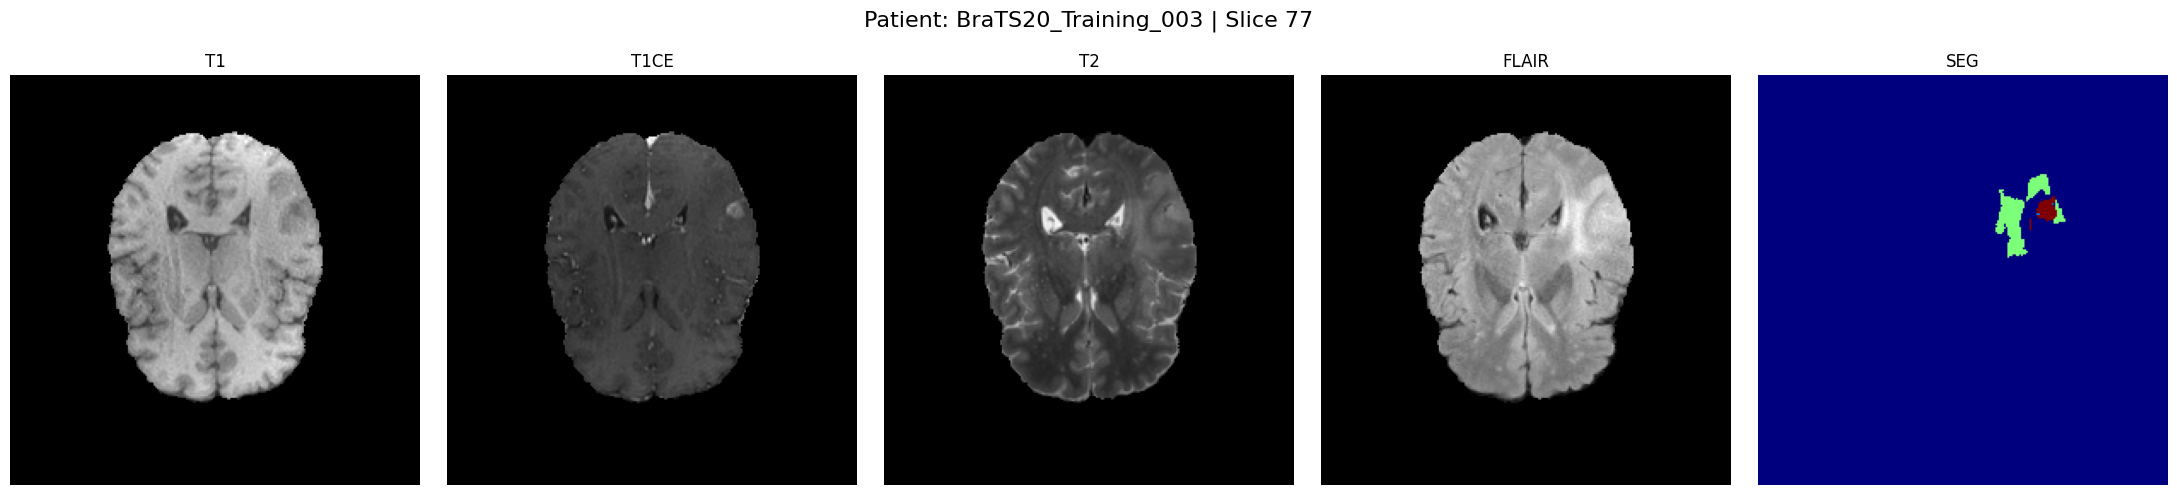

In [ ]:
def visualize_random_patient(patients_dict, slice_idx=None):
    """
    Visualize one folder of images with random patient.
    """
    # Pick a random patient
    patient_id = random.choice(list(patients_dict.keys()))
    data = patients_dict[patient_id]
    modalities = ['T1', 'T1CE', 'T2', 'FLAIR', 'SEG']

    # Use middle slice if none given
    if slice_idx is None:
        slice_idx = data['T1'].shape[2] // 2

    # Plot all modalities
    fig, axes = plt.subplots(1, 5, figsize=(22, 5))
    for i, mod in enumerate(modalities):
        img = data[mod][:, :, slice_idx]
        axes[i].imshow(img.T, cmap='gray' if mod != 'SEG' else 'jet', origin='lower')
        axes[i].set_title(mod)
        axes[i].axis('off')

    plt.suptitle(f"Patient: {patient_id} | Slice {slice_idx}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

visualize_random_patient(patients)

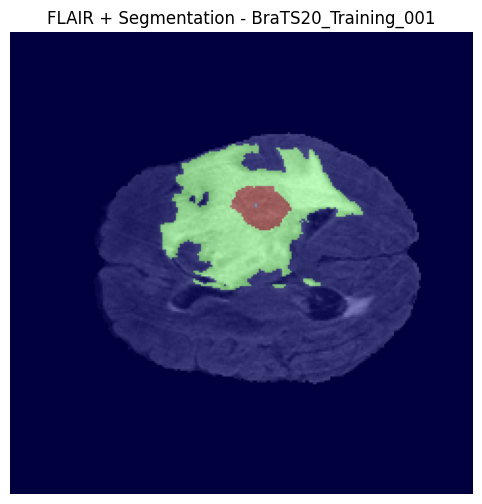

In [ ]:
# Get the first available patient
patient_key = list(patients.keys())[0]
slice_idx = 77
flair = patients[patient_key]['FLAIR']
seg = patients[patient_key]['SEG']

plt.figure(figsize=(12, 6))
plt.imshow(flair[:, :, slice_idx], cmap='gray')
plt.imshow(seg[:, :, slice_idx], cmap='jet', alpha=0.5)
plt.title(f'FLAIR + Segmentation - {patient_key}')
plt.axis('off')
plt.show()

# Apply Brain Mask

In [ ]:
masked_patients = {}

for patient_id, data in patients.items():

    #Create brain mask by combining modalities
    #Any voxel > 0 in ANY modality is considered part of the brain
    mask = np.zeros_like(data['T1'], dtype=bool)
    for mod in ['T1', 'T1CE', 'T2', 'FLAIR']:
        mask |= (data[mod] > 0)

    #Store masked data and mask image
    masked_patients[patient_id] = {
        "masked_modalities": {
            "T1":    data['T1'],
            "T1CE":  data['T1CE'],
            "T2":    data['T2'],
            "FLAIR": data['FLAIR'],
        },
        "mask_img": nib.Nifti1Image(mask.astype(np.uint8), np.eye(4)),
        "SEG" : data["SEG"]
    }

    print(f"{patient_id}: Brain voxels = {mask.sum():,}")

BraTS20_Training_001: Brain voxels = 1,342,885
BraTS20_Training_002: Brain voxels = 1,539,198
BraTS20_Training_003: Brain voxels = 1,261,120


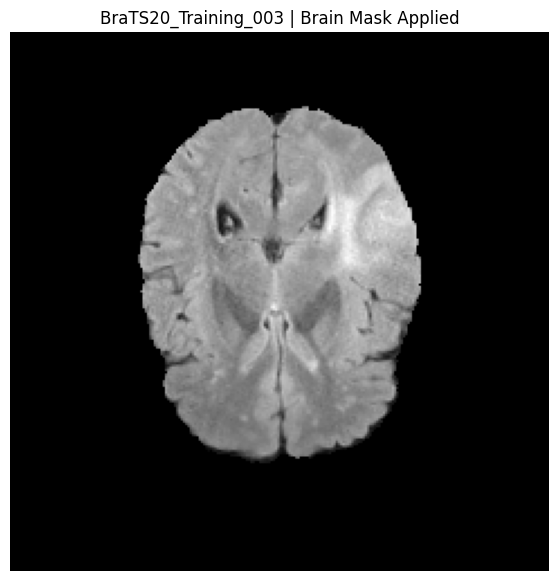

In [ ]:
pid = random.choice(list(masked_patients.keys()))
mask = masked_patients[pid]["mask_img"].get_fdata().astype(bool)
flair = masked_patients[pid]["masked_modalities"]["FLAIR"]

z = flair.shape[2] // 2
plt.figure(figsize=(7,7))
plt.imshow((flair * mask)[:, :, z].T, cmap='gray', origin='lower')
plt.title(f"{pid} | Brain Mask Applied")
plt.axis("off")
plt.show()

# Intensity Clipping

In [ ]:
def intensity_clipping(volume, mask=None, lower=1, upper=99):
    """
    percentile intensity clipping on an MRI volume.
    Taken from nnU-Net (Isensee et al., Nature Methods 2021).
    """

    # If no mask provided, clip across entire non-zero voxels
    if mask is None:
        mask = volume > 0

    # Extract values ONLY inside the brain (avoid background = 0)
    brain_voxels = volume[mask]

    # Compute percentile bounds
    p_low, p_high = np.percentile(brain_voxels, [lower, upper])

    # Clip intensities
    clipped = np.clip(volume, p_low, p_high)

    return clipped

# Z Score Normalization

In [ ]:
def zscore_normalization(volume, mask=None):
    """
    Z-score normalize inside the brain mask (mean=0, std=1).
    Validated by DeepCluster (ECCV 2018), FSL, SPM, FreeSurfer, and nnU-Net.
    """

    if mask is None:
        mask = volume > 0  # avoid background

    brain_voxels = volume[mask]

    mean = brain_voxels.mean()
    std  = brain_voxels.std()

    if std == 0:
        # Extremely rare, but prevents division by zero
        return volume - mean

    normed = (volume - mean) / std
    return normed

# Multi-Channel Feature Vector

In [ ]:
voxel_data = {}   # stores X matrix per patient

for pid, entry in masked_patients.items():

    mask = entry["mask_img"].get_fdata().astype(bool)
    mods = entry["masked_modalities"]

    # 1. Intensity clipping
    for mod in ["T1", "T1CE", "T2", "FLAIR"]:
        mods[mod] = intensity_clipping(mods[mod], mask=mask)

    # 2. Z-score normalization
    for mod in ["T1", "T1CE", "T2", "FLAIR"]:
        mods[mod] = zscore_normalization(mods[mod], mask=mask)

    masked_patients[pid]["masked_modalities"] = mods

# Crop Volumes

In [ ]:
def center_crop(volume, crop_size=128):
    """
    Center crop a 3D MRI volume to crop_size^3.
    """
    x, y, z = volume.shape
    cx, cy, cz = x//2, y//2, z//2
    half = crop_size // 2

    return volume[
        cx - half : cx + half,
        cy - half : cy + half,
        cz - half : cz + half
    ]

def get_bbox(mask):
    """Return bounding box of non-zero region."""
    coords = np.array(np.where(mask))
    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)
    return (zmin, zmax, ymin, ymax, xmin, xmax)

In [ ]:
cropped_patients = {}

for pid, entry in masked_patients.items():
    mods = entry["masked_modalities"]
    seg  = entry["SEG"]
    mask = entry["mask_img"].get_fdata().astype(bool)

    # 1️⃣ Compute bounding box ONCE from brain mask
    zmin, zmax, ymin, ymax, xmin, xmax = get_bbox(mask)

    # 2️⃣ Crop everything using SAME bounding box
    cropped_mods = {}
    for mod in ["T1", "T1CE", "T2", "FLAIR"]:
        vol = mods[mod]
        cropped_mods[mod] = vol[zmin:zmax+1,
                                ymin:ymax+1,
                                xmin:xmax+1]

    cropped_seg = seg[zmin:zmax+1,
                      ymin:ymax+1,
                      xmin:xmax+1]

    cropped_mask = mask[zmin:zmax+1,
                        ymin:ymax+1,
                        xmin:xmax+1]

    # 3️⃣ Save them
    cropped_patients[pid] = {
        "masked_modalities": cropped_mods,
        "mask": cropped_mask,
        "SEG": cropped_seg
    }

    print(f"{pid} cropped to {cropped_mods['FLAIR'].shape}")

BraTS20_Training_001 cropped to (137, 173, 135)
BraTS20_Training_002 cropped to (134, 187, 140)
BraTS20_Training_003 cropped to (129, 163, 135)


# ROI Selection

In [ ]:
roi_patients = {}

for pid, entry in cropped_patients.items():
    mods = entry["masked_modalities"]
    flair = mods["FLAIR"]
    t1ce  = mods["T1CE"]
    mask  = entry["mask"]     # brain mask in cropped space

    # ----------- SIMPLE ROI (older version) -----------
    # 1) Basic condition: include all non-zero FLAIR voxels inside the brain mask
    roi = (flair > 0) & mask

    # 2) Optional soft T1CE enhancement contribution
    #    Helps WT slightly, but does not over-prune like the new ROI
    t1ce_thr = np.percentile(t1ce[mask], 75)
    roi = roi | (t1ce > t1ce_thr)

    # No morphological operations
    # No connected component pruning
    # Purely intensity-based — what your earlier pipeline assumed

    roi_patients[pid] = {
        "roi": roi,
        "SEG": entry["SEG"],
        "masked_modalities": mods,
        "mask": mask
    }

    print(f"{pid}: ROI voxels = {roi.sum()} / {mask.sum()}")

BraTS20_Training_001: ROI voxels = 776548 / 1342885
BraTS20_Training_002: ROI voxels = 980822 / 1539198
BraTS20_Training_003: ROI voxels = 854943 / 1261120


# Feature Extraction

In [ ]:
scaler = StandardScaler()
# pca = PCA(n_components=3, random_state=42)   # comment out to disable PCA

voxel_data = {}

for pid, entry in roi_patients.items():
    roi = entry["roi"]
    mods = entry["masked_modalities"]

    X = np.vstack([
        mods["T1"][roi],
        mods["T1CE"][roi],
        mods["T2"][roi],
        mods["FLAIR"][roi]
    ]).T

    # If you want to use pca, do pca.fit instead
    X_std = scaler.fit_transform(X)

    voxel_data[pid] = {
        "X_std": X_std,  # If using pca change to X_pca
        "roi": roi,
        "SEG": entry["SEG"],
        "masked_modalities": mods,
        "mask": entry["mask"]
    }

    print(f"{pid}: Using NON-PCA standardized features → {X_std.shape}")

BraTS20_Training_001: Using NON-PCA standardized features → (776548, 4)
BraTS20_Training_002: Using NON-PCA standardized features → (980822, 4)
BraTS20_Training_003: Using NON-PCA standardized features → (854943, 4)


# Dimensionality Reduction (Optional PCA)

In [ ]:
print("\nFitting PCA globally...")

# Fit PCA on all patients' standardized data
all_X_std = np.concatenate([entry["X_std"] for entry in voxel_data.values()])
print("All X_std shape:", all_X_std.shape)

pca = PCA(n_components=3, random_state=42)
pca.fit(all_X_std)

# Transform each patient
for pid, entry in voxel_data.items():
    X_std = entry["X_std"]
    entry["X_pca"] = pca.transform(X_std)
    print(f"{pid}: X_pca shape = {entry['X_pca'].shape}")

print("PCA transformation complete.\n")


Fitting PCA globally...
All X_std shape: (2612313, 4)
BraTS20_Training_001: X_pca shape = (776548, 3)
BraTS20_Training_002: X_pca shape = (980822, 3)
BraTS20_Training_003: X_pca shape = (854943, 3)
PCA transformation complete.



In [ ]:
pid = list(voxel_data.keys())[0]
X_pca = voxel_data[pid]["X_pca"]

print(f"\nPCA QC for {pid}")
print("PCA component means:", X_pca.mean(axis=0))
print("PCA component stds :", X_pca.std(axis=0))


PCA QC for BraTS20_Training_001
PCA component means: [1.45840121e-14 5.02742999e-16 4.11756110e-15]
PCA component stds : [1.64040371 0.72656816 0.79468668]


# Gaussian Mixture Model Clustering

In [ ]:
k = 4  # number of clusters

for pid, entry in voxel_data.items():
    X_pca = entry["X_pca"]
    roi = entry["roi"]
    mask = entry["mask"]

    print(f"{pid}: X_pca shape = {X_pca.shape}")

    gmm = GaussianMixture(
        n_components=k,
        covariance_type="diag",
        random_state=42,
        n_init=1,
        max_iter=50,
    )

    # 1D labels for every voxel
    labels_1d = gmm.fit_predict(X_pca).astype(np.int32)

    # Store 1D labels
    entry["gmm_labels"] = labels_1d

    # Create 3D label image
    labels_3d = np.zeros_like(mask, dtype=np.int32)
    labels_3d[roi] = labels_1d
    entry["gmm_labels_3d"] = labels_3d

BraTS20_Training_001: X_pca shape = (776548, 3)
BraTS20_Training_002: X_pca shape = (980822, 3)
BraTS20_Training_003: X_pca shape = (854943, 3)


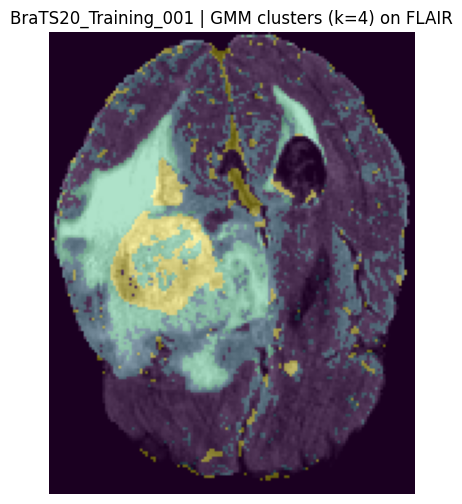

In [ ]:
# Pick a patient to visualize
pid = list(voxel_data.keys())[0]  # or any specific ID
entry = voxel_data[pid]
flair_vol = entry["masked_modalities"]["FLAIR"]
labels_vol = entry["gmm_labels_3d"]

slice_idx = flair_vol.shape[2] // 2

plt.figure(figsize=(12, 6))
plt.imshow(flair_vol[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.imshow(labels_vol[:, :, slice_idx].T,
           cmap="viridis",
           alpha=0.4,
           origin="lower")
plt.title(f"{pid} | GMM clusters (k={k}) on FLAIR")
plt.axis("off")
plt.show()

# Evaluation: Cluster Alignment and Dice Scores

In [ ]:
# --- Dice helper ---
def dice(pred, true):
    pred = pred.astype(bool)
    true = true.astype(bool)

    if pred.sum() + true.sum() == 0:
        return 1.0
    if pred.sum() == 0 or true.sum() == 0:
        return 0.0

    return 2 * np.sum(pred & true) / (pred.sum() + true.sum())

In [ ]:
# 1) Align GMM clusters → GT labels (per patient)
gmm_aligned_labels = {}

for pid, entry in voxel_data.items():
    print(f"\nAligning GMM clusters for {pid}")

    roi = entry["roi"]
    gmm_labels = entry["gmm_labels"]        # shape (N_voxels,)

    # Get SEG in ROI space
    seg_vol = entry["SEG"]
    seg_flat = seg_vol[roi].astype(int)  # shape (N_voxels,)

    if len(seg_flat) != len(gmm_labels):
        print(f"❌ Length mismatch for {pid}: seg={len(seg_flat)}, gmm={len(gmm_labels)}")
        continue

    # Map BraTS labels {1,2,4} → {0,1,2}, everything else → -1 (ignore)
    seg_map = {1: 0, 2: 1, 4: 2}
    true_seg = np.array([seg_map.get(int(v), -1) for v in seg_flat])

    # Only use voxels with valid GT labels for alignment
    valid_idx = true_seg >= 0
    true_valid = true_seg[valid_idx]
    pred_valid = gmm_labels[valid_idx]

    # Confusion matrix rows = GT, cols = clusters
    cm = confusion_matrix(true_valid, pred_valid, labels=[0, 1, 2])

    # Hungarian matching to find best cluster → GT mapping
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize agreement
    mapping = dict(zip(col_ind, row_ind))
    print(f"{pid}: cluster→GT mapping: {mapping}")

    # Apply mapping to ALL voxels
    aligned = np.array([mapping.get(int(c), -1) for c in gmm_labels])
    gmm_aligned_labels[pid] = aligned


Aligning GMM clusters for BraTS20_Training_001
BraTS20_Training_001: cluster→GT mapping: {np.int64(1): np.int64(0), np.int64(2): np.int64(1), np.int64(0): np.int64(2)}

Aligning GMM clusters for BraTS20_Training_002
BraTS20_Training_002: cluster→GT mapping: {np.int64(0): np.int64(0), np.int64(2): np.int64(1), np.int64(1): np.int64(2)}

Aligning GMM clusters for BraTS20_Training_003
BraTS20_Training_003: cluster→GT mapping: {np.int64(2): np.int64(0), np.int64(1): np.int64(1), np.int64(0): np.int64(2)}


In [ ]:
# 2) Compute Dice scores (WT, TC, ET) for each patient
dice_scores_gmm = {}

for pid, entry in voxel_data.items():
    if pid not in gmm_aligned_labels:
        continue

    print(f"\nComputing Dice for GMM – {pid}")

    roi = entry["roi"]
    seg_vol = entry["SEG"]
    seg_flat = seg_vol[roi].astype(int)

    seg_map = {1: 0, 2: 1, 4: 2}
    true_seg = np.array([seg_map.get(int(v), -1) for v in seg_flat])

    pred_seg = gmm_aligned_labels[pid]

    if len(pred_seg) != len(true_seg):
        print(f"Shape mismatch: pred={len(pred_seg)}, true={len(true_seg)}")
        continue

    # --- Region definitions (tweak if your assignment defines them differently) ---

    # Whole tumor: any non-background tumor label
    true_WT = true_seg > 0
    pred_WT = pred_seg > 0

    # Tumor core: example using labels {0,2} in your remapped scheme
    true_TC = np.isin(true_seg, [0, 2])
    pred_TC = np.isin(pred_seg, [0, 2])

    # Enhancing tumor: label 2
    true_ET = (true_seg == 2)
    pred_ET = (pred_seg == 2)

    WT = dice(pred_WT, true_WT)
    TC = dice(pred_TC, true_TC)
    ET = dice(pred_ET, true_ET)

    dice_scores_gmm[pid] = (WT, TC, ET)
    print(f"{pid}: WT={WT:.4f}, TC={TC:.4f}, ET={ET:.4f}")


Computing Dice for GMM – BraTS20_Training_001
BraTS20_Training_001: WT=0.4033, TC=0.0039, ET=0.0000

Computing Dice for GMM – BraTS20_Training_002
BraTS20_Training_002: WT=0.2145, TC=0.0001, ET=0.0002

Computing Dice for GMM – BraTS20_Training_003
BraTS20_Training_003: WT=0.1156, TC=0.0003, ET=0.0008


# Results Summary

In [ ]:
def summarize_single_method(dice_scores, method_name="Method"):
    """
    dice_scores: dict like {pid: (WT, TC, ET)}
    Returns: a pandas DataFrame with summary stats for WT, TC, ET.
    """

    # Collect into arrays
    WT = np.array([v[0] for v in dice_scores.values()])
    TC = np.array([v[1] for v in dice_scores.values()])
    ET = np.array([v[2] for v in dice_scores.values()])

    summary = {
        "Method": method_name,
        "WT_mean": WT.mean(),   "WT_median": np.median(WT), "WT_std": WT.std(),
        "WT_min": WT.min(),     "WT_max": WT.max(),
        "TC_mean": TC.mean(),   "TC_median": np.median(TC), "TC_std": TC.std(),
        "TC_min": TC.min(),     "TC_max": TC.max(),
        "ET_mean": ET.mean(),   "ET_median": np.median(ET), "ET_std": ET.std(),
        "ET_min": ET.min(),     "ET_max": ET.max(),
    }

    df = pd.DataFrame([summary])
    display(df)
    print("\nLaTeX table:\n")
    print(df.to_latex(index=False, float_format="%.4f"))
    return df


_ = summarize_single_method(dice_scores_gmm, "Gaussian Mixture")

,Method,WT_mean,WT_median,WT_std,WT_min,WT_max,TC_mean,TC_median,TC_std,TC_min,TC_max,ET_mean,ET_median,ET_std,ET_min,ET_max
0,Gaussian Mixture,0.244463,0.214509,0.119324,0.115621,0.403261,0.001423,0.000334,0.001726,0.000076,0.003859,0.000329,0.000176,0.000342,0.000008,0.000803



LaTeX table:

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
Method & WT_mean & WT_median & WT_std & WT_min & WT_max & TC_mean & TC_median & TC_std & TC_min & TC_max & ET_mean & ET_median & ET_std & ET_min & ET_max \\
\midrule
Gaussian Mixture & 0.2445 & 0.2145 & 0.1193 & 0.1156 & 0.4033 & 0.0014 & 0.0003 & 0.0017 & 0.0001 & 0.0039 & 0.0003 & 0.0002 & 0.0003 & 0.0000 & 0.0008 \\
\bottomrule
\end{tabular}

